In [ ]:
!pip install darts

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.2/52.2 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 6.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0

In [ ]:
# Import all required libraries
import pandas as pd
import numpy as np
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler
from darts.models import ExponentialSmoothing, ARIMA, FFT


# pd.set_option('display.max_rows', 15)
# pd.set_option('display.max_columns', 500)
# pd.set_option('display.width', 1000)

# Graphics in SVG format are more sharp and legible
%config InlineBackend.figure_format = 'svg'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **1. Read and Analize Data**

### 1.1. Data Preparation

In [ ]:
# Read the dataset
file_path = '/content/drive/MyDrive/Datasets/T10Y2Y_max.csv'    # Full dataset from 1976 to present days
df = pd.read_csv(file_path)
df.head(3)

,DATE,T10Y2Y
0,1976-06-01,0.68
1,1976-06-02,0.71
2,1976-06-03,0.70


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12564 entries, 0 to 12563
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   DATE    12564 non-null  object
 1   T10Y2Y  12564 non-null  object
dtypes: object(2)
memory usage: 196.4+ KB


In [ ]:
df['DATE'] = pd.to_datetime(df['DATE'])
missed_values = df.isnull().sum()
missed_values

DATE      0
T10Y2Y    0
dtype: int64

In [ ]:
df.describe(include='all')

,DATE,T10Y2Y
count,12564,12564
unique,NaN,500
top,NaN,.
freq,NaN,528
mean,2000-06-28 16:47:54.498567296,NaN
min,1976-06-01 00:00:00,NaN
25%,1988-06-14 18:00:00,NaN
50%,2000-06-28 12:00:00,NaN
75%,2012-07-12 06:00:00,NaN
max,2024-07-26 00:00:00,NaN


**Бачимо що значення в 'T10Y2Y' в форматі 'object' та містять ' . ', переведемо у числовий формат та позбавимось коми.**

In [ ]:
# Remove all '.' values from the feature 'T10Y2Y'
df['T10Y2Y'] = pd.to_numeric(df['T10Y2Y'].replace('.', np.nan))
df = df.dropna()

In [ ]:
df.describe()

,DATE,T10Y2Y
count,12036,12036.000000
mean,2000-07-04 22:28:06.939182464,0.864575
min,1976-06-01 00:00:00,-2.410000
25%,1988-06-27 18:00:00,0.190000
50%,2000-07-05 12:00:00,0.820000
75%,2012-07-13 18:00:00,1.500000
max,2024-07-26 00:00:00,2.910000
std,NaN,0.926663


**Зараз все добре**

## **2. Time Series Analysis with Pandas and Statsmodels**

### 2.1. Time Series Visualization

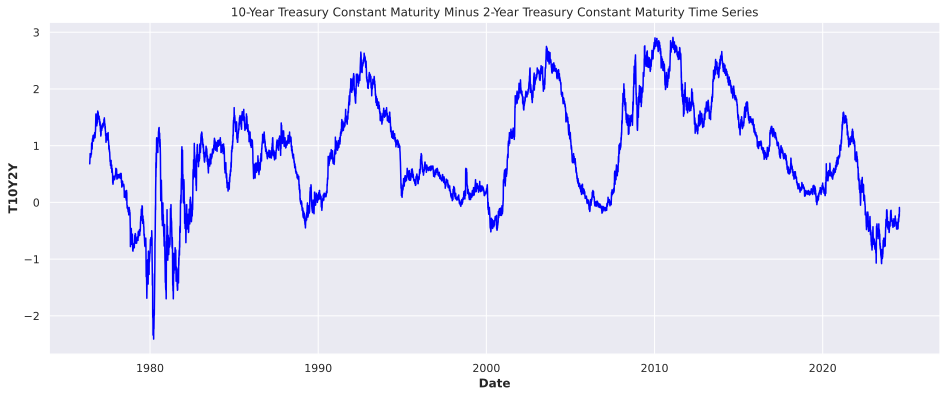

In [ ]:
# Plot the T10Y2Y values over all time
plt.figure(figsize=(16, 6))
plt.plot(df['DATE'], df['T10Y2Y'], label='T10Y2Y', color='blue')
plt.xlabel('Date')
plt.ylabel('T10Y2Y')
plt.title('10-Year Treasury Constant Maturity Minus 2-Year Treasury Constant Maturity Time Series')
plt.grid(True)
plt.show()

### 2.2. Trends

In [ ]:
# Calculate and plot moving averages (90 and 180 days) to ideentify trends
df_1 = df.copy()
df_1['Moving_avg_90'] = df_1['T10Y2Y'].rolling(window=90).mean()
df_1['Moving_avg_180'] = df_1['T10Y2Y'].rolling(window=180).mean()

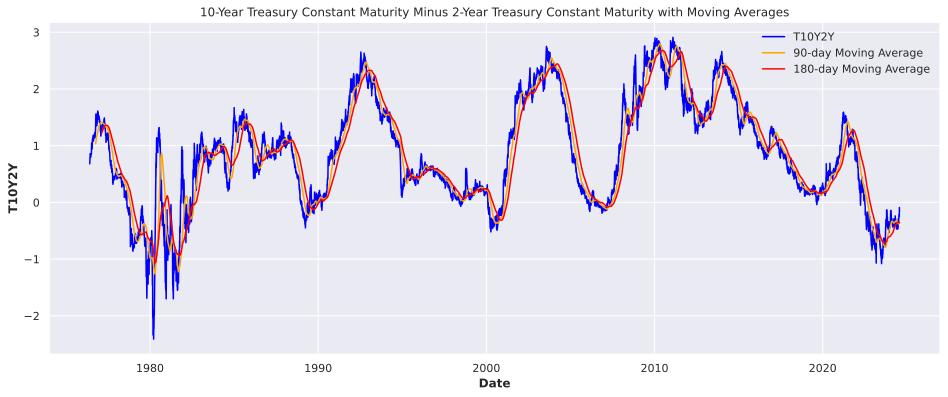

In [ ]:
# Plot our findings
plt.figure(figsize=(16, 6))
plt.plot(df_1['DATE'], df_1['T10Y2Y'], label='T10Y2Y', c='blue')
plt.plot(df_1['DATE'], df_1['Moving_avg_90'], label='90-day Moving Average', color='orange')
plt.plot(df_1['DATE'], df_1['Moving_avg_180'], label='180-day Moving Average', color='red')
plt.xlabel('Date')
plt.ylabel('T10Y2Y')
plt.title('10-Year Treasury Constant Maturity Minus 2-Year Treasury Constant Maturity with Moving Averages')
plt.legend()
plt.grid(True)
plt.show()


**180-дений середній ковзний гарно змягшує короткострокові коливання та показує довгостроковий тренд.**

### 2.3. Seasonality and Residuals

In [ ]:
# Calculate seasonal decomposition
result = seasonal_decompose(df_1.set_index('DATE')['T10Y2Y'], model='additive', period=365)

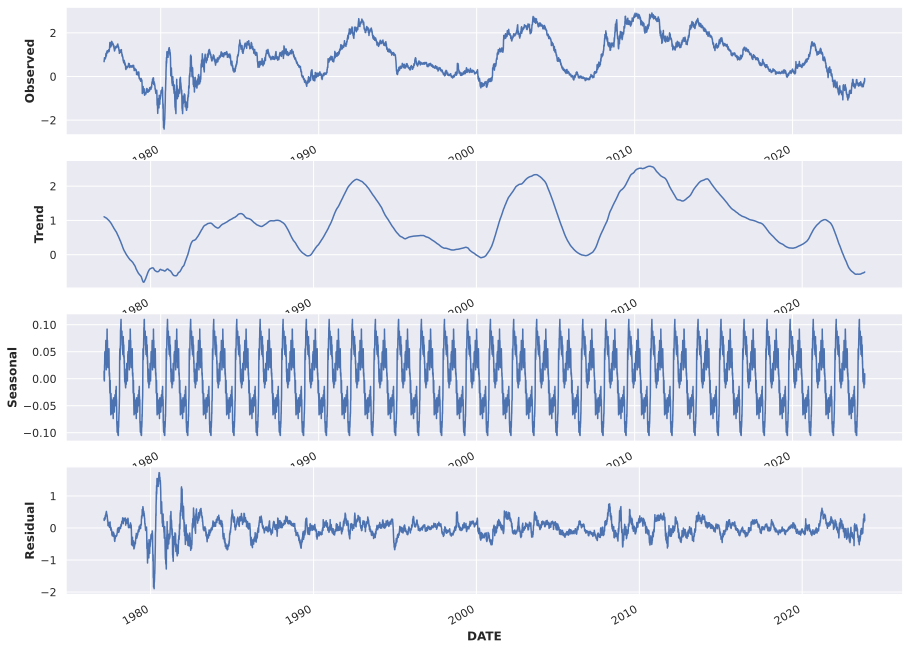

In [ ]:
# Plot
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15, 12))
result.observed.plot(ax=ax1)
ax1.set_ylabel('Observed')
result.trend.plot(ax=ax2)
ax2.set_ylabel('Trend')
result.seasonal.plot(ax=ax3)
ax3.set_ylabel('Seasonal')
result.resid.plot(ax=ax4)
ax4.set_ylabel('Residual')
plt.show()

* **Observed: Оригінальні time series дані.**
* **Trend: Довгостроковий рух в time series.**
* **Seasonal: Повторювані короткострокові цикли в time series.**
* **Residual: шум.**

**Я взяв для роботи ряд за весь термін з 1976 року. Думаю якщо проаналізувати десятирічний термін, можна побачити більш виразні тренди та сезонність.**

## **3. Time Series Analysis with Darts**

**Для роботи з Darts я взяв меньший датасет - за 5 років**

## 3.1. Arrange and Split the Data

In [ ]:
# Read the dataset
file_path = '/content/drive/MyDrive/Datasets/T10Y2Y.csv'
data = pd.read_csv(file_path)

In [ ]:
data.describe()

,DATE,T10Y2Y
count,1306,1306
unique,1306,255
top,2019-07-23,.
freq,1,54


In [ ]:
# Remove all '.' values from the feature 'T10Y2Y'
data['T10Y2Y'] = pd.to_numeric(data['T10Y2Y'].replace('.', np.nan))
data = data.dropna()

# Convert the 'DATE' column to datetime and the 'T10Y2Y' column to float
data['DATE'] = pd.to_datetime(data['DATE'])

data.loc[:, 'T10Y2Y'] = data['T10Y2Y'].astype(float)
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1252 entries, 0 to 1305
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   DATE    1252 non-null   datetime64[ns]
 1   T10Y2Y  1252 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 29.3 KB


<ipython-input-74-821c88b96dd7>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['DATE'] = pd.to_datetime(data['DATE'])


In [ ]:
# Create a TimeSeries object: we use parameter freq='B' to use Busines Days frequency to fill missing data
series = TimeSeries.from_dataframe(data, 'DATE', 'T10Y2Y', fill_missing_dates=True, freq='B')

In [ ]:
# # Scale the series (optional but recommended for some models)
# scaler = Scaler()
# series = scaler.fit_transform(series)

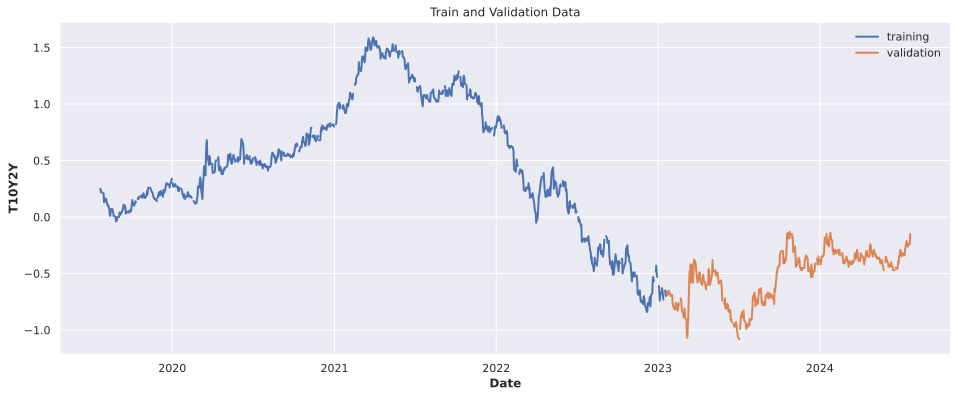

In [ ]:
# Split the series into training and validation sets (80% train, 20% validation)
train, val = series.split_before(0.7)

# Plot the datasets
plt.figure(figsize=(16, 6))
train.plot(label="training")
val.plot(label="validation")
plt.title('Train and Validation Data')
plt.xlabel('Date')
plt.ylabel('T10Y2Y')
plt.show()

## 3.2. Exponential Smoothing Model (Darts)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


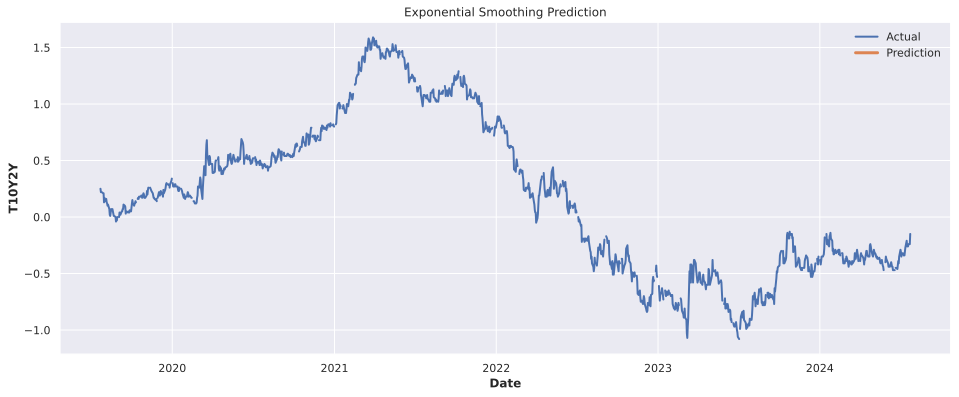

In [ ]:
# Train the Exponential Smoothing model
model_es = ExponentialSmoothing()
model_es.fit(train)

# Make predictions
prediction_es = model_es.predict(len(val))

# Plot the results
plt.figure(figsize=(16, 6))
series.plot(label='Actual')
prediction_es.plot(label='Prediction', lw=3)
plt.title('Exponential Smoothing Prediction')
plt.xlabel('Date')
plt.ylabel('T10Y2Y')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Check values of prediction
print(prediction_es[:5])

<TimeSeries (DataArray) (DATE: 5, component: 1, sample: 1)> Size: 40B
array([[[nan]],

       [[nan]],

       [[nan]],

       [[nan]],

       [[nan]]])
Coordinates:
  * DATE       (DATE) datetime64[ns] 40B 2023-01-20 2023-01-23 ... 2023-01-26
  * component  (component) object 8B 'T10Y2Y'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None


* **В предикшен я отримав самі NAN - думаю що модель Exponential Smoothing не змогла зійтись на даних, або в мене десь помилка...**
* **Спробую натренувати на ціх даних модель ARIMA**

## 3.3. ARIMA Model (Darts)

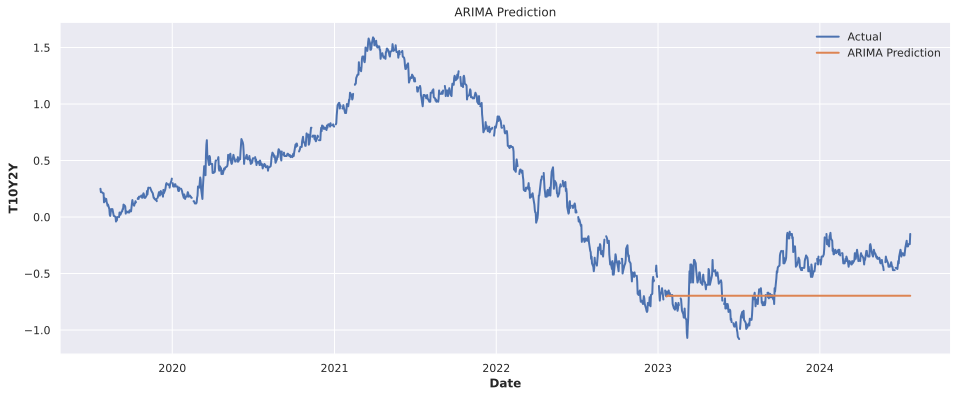

In [ ]:
# Fit an ARIMA model
model_arima = ARIMA()
model_arima.fit(train)

# Make predictions
prediction_arima = model_arima.predict(len(val))

# Plot the results
plt.figure(figsize=(16, 6))
series.plot(label='Actual')
prediction_arima.plot(label='ARIMA Prediction')
plt.title('ARIMA Prediction')
plt.xlabel('Date')
plt.ylabel('T10Y2Y')
plt.legend()
plt.grid(True)
plt.show()


## 3.4. Confidence Intervals for ES and ARIMA Models

In [ ]:
# Visualize Confidence Intervals for models
prediction_es_interval = model_es.predict(len(val), num_samples=1000)
prediction_arima_interval = model_arima.predict(len(val), num_samples=1000)

/usr/local/lib/python3.10/dist-packages/numpy/lib/nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,


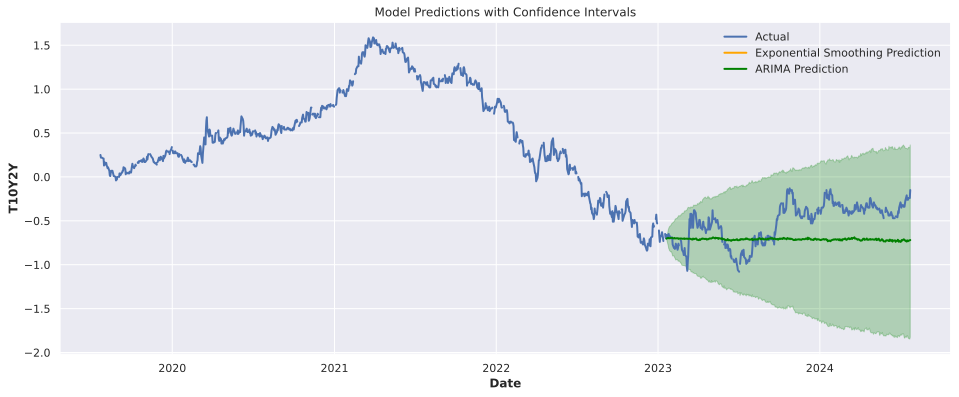

In [ ]:
# Plot the results with confidence intervals
plt.figure(figsize=(16, 6))
series.plot(label='Actual')
prediction_es_interval.plot(label='Exponential Smoothing Prediction', low_quantile=0.05, high_quantile=0.95, color='orange')
prediction_arima_interval.plot(label='ARIMA Prediction', low_quantile=0.05, high_quantile=0.95, color='green')
plt.title('Model Predictions with Confidence Intervals')
plt.xlabel('Date')
plt.ylabel('T10Y2Y')
plt.legend()
plt.grid(True)
plt.show()

## 3.5. Fast Fourier Transform Model (Darts)

In [ ]:
# Fast Fourie Transform
model_fft = FFT(nr_freqs_to_keep=20, trend= "poly", trend_poly_degree=2)

# Fit the model
model_fft.fit(series)

# Make prediction
prediction_fft = model_fft.predict(50)

# Check the prediction values
# prediction_fft.values()

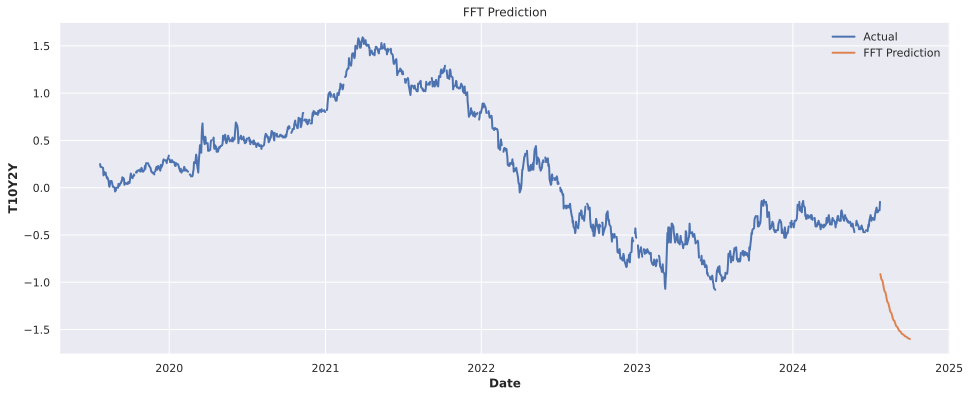

In [ ]:
# Plot the results
plt.figure(figsize=(16, 6))
series.plot(label='Actual')
prediction_fft.plot(label='FFT Prediction')
plt.title('FFT Prediction')
plt.xlabel('Date')
plt.ylabel('T10Y2Y')
plt.legend()
plt.grid(True)
plt.show()

## **4. Time Series Analysis with Statsmodels**

In [ ]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Read the dataset
file_path = '/content/drive/MyDrive/Datasets/T10Y2Y.csv'
data_2 = pd.read_csv(file_path)

In [ ]:
# Convert the DATE column to datetime if the values are in other format
if not pd.api.types.is_datetime64_any_dtype(data_2.index):
    data_2['DATE'] = pd.to_datetime(data_2['DATE'])
    data_2.set_index('DATE', inplace=True)

# Replace '.' with NaN and convert the T10Y2Y column to numeric
data_2['T10Y2Y'] = data_2['T10Y2Y'].replace('.', float('nan')).astype(float)

# Interpolate missing values
data_2['T10Y2Y'] = data_2['T10Y2Y'].interpolate()

# Split into train and val sets
train = data_2[:'2022-12-31']
val = data_2['2023-01-01':]

# Fit the model
model_es_stat = ExponentialSmoothing(train, trend='add', seasonal=None, damped_trend=True).fit()

# Make predictions
prediction_es_stat = model_es_stat.forecast(len(val))

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)


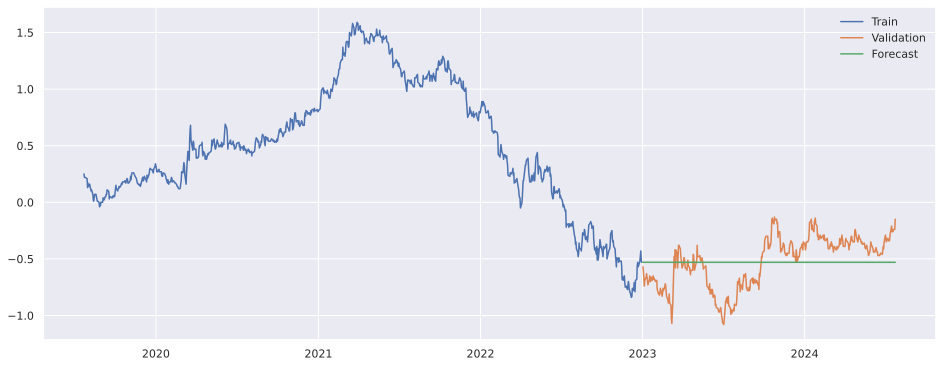

In [ ]:
# Plot the results
plt.figure(figsize=(16, 6))
plt.plot(train, label='Train')
plt.plot(val, label='Validation')
plt.plot(prediction_es_stat, label='Forecast')
plt.legend()
plt.show()

Вдалося натренувати модель ***ExponentialSmoothing*** з бібліотеки ***statsmodels***

In [ ]:
######################## END OF NOTEBOOK #############################